# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install('ipywidgets')

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import ipywidgets
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
# Define transforms
## YOUR CODE HERE ##
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
#transform = transforms.ToTensor()

# Create training set and define training dataloader
## YOUR CODE HERE ##
training_data = torchvision.datasets.MNIST(root="data", 
                           train=True, 
                           download=True,
                           transform=transform)

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=28, shuffle=True)

# Create test set and define test dataloader
## YOUR CODE HERE ##
test_data = torchvision.datasets.MNIST(root="data", 
                           train=False, 
                           download=True,
                           transform=transform)

test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=28, shuffle=False)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

Preprocessing is required incase if we want to convert raw data to tensors, so that it will be conducive to use by neural network. In our case with MNIST dataset, with ToTensor() we can convert to tensors. This MNIST dataset is coming as (C,W,H) 1,28,28. I dont see a need to encode any non numerical or convert images or tokenize any info with this dataset.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
5


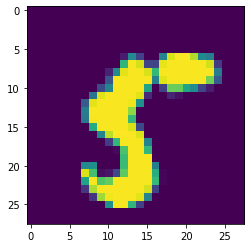

7


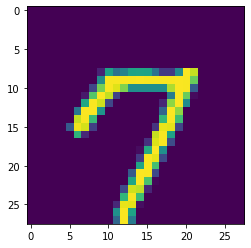

8


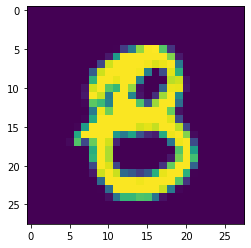

2


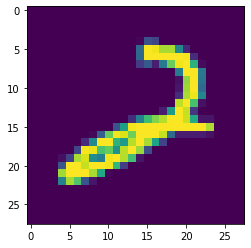

9


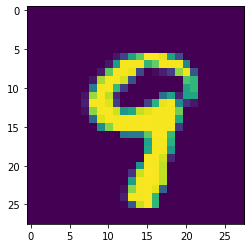

In [4]:
# Explore data
## YOUR CODE HERE ##
print(training_data)
#print(training_data[0][0].shape)

#training_flatten = torch.flatten(training_data[0][0])
#print(training_flatten.shape)

show5(train_dataloader)
#show5(test_dataloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
## YOUR CODE HERE ##
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.softmax = F.softmax
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
net = Net()

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
## YOUR CODE HERE ##
# Optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Loss function
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [7]:

num_epochs = 10

# Establish a list for our history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    net.train()
    train_loss = 0.0
    train_correct = 0
    for i, data in enumerate(train_dataloader):
        # data is a list of [inputs, labels]
        inputs, labels = data

        # Pass to GPU if available.
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_dataloader):.2f}% training loss: {train_loss/len(train_dataloader):.5f}')
    train_loss_history.append(train_loss/len(train_dataloader))


    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_dataloader:
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(test_dataloader):.2f}% validation loss: {val_loss/len(test_dataloader):.5f}')
    val_loss_history.append(val_loss/len(test_dataloader))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

Plot the training loss (and validation loss/accuracy, if recorded).

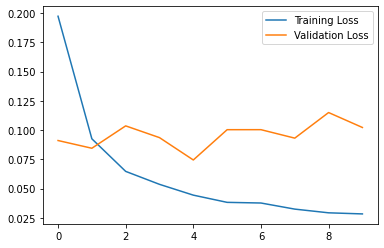

In [11]:
## YOUR CODE HERE ##
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [16]:
## YOUR CODE HERE ##
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
batch_size = 4

net.eval() # prep model for evaluation

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.102442

Test Accuracy of     0: 99% (144/145)
Test Accuracy of     1: 98% (154/156)
Test Accuracy of     2: 97% (141/144)
Test Accuracy of     3: 96% (146/151)
Test Accuracy of     4: 95% (138/144)
Test Accuracy of     5: 97% (127/130)
Test Accuracy of     6: 100% (126/126)
Test Accuracy of     7: 97% (154/158)
Test Accuracy of     8: 98% (133/135)
Test Accuracy of     9: 97% (139/143)

Test Accuracy (Overall): 97% (1402/1432)


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [ ]:
## YOUR CODE HERE ##

## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
## YOUR CODE HERE ##